In [72]:
import matplotlib.pyplot as plt
import pandas as pd

marte_raw = pd.read_csv('marte_vs_nlwest_19_22.csv',
                        usecols=['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'pitcher', 'zone', 'des', 'p_throws', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name', 'spin_axis'])

# rename the primary response variable
marte_raw.rename(columns={'estimated_woba_using_speedangle': 'xwOBA'}, inplace=True)
print(f"data-set shape prior to filtering: {marte_raw.shape}")

# filter sacrifice events; if woba_denom is NaN, then sacrifice event
marte_raw.dropna(axis='rows', subset=['woba_denom'], how='any', inplace=True)
print(f"data-set shape after to filtering sac hits: {marte_raw.shape}")

data-set shape prior to filtering: (867, 30)
data-set shape after to filtering sac hits: (865, 30)


- release_speed
    - Pitch velocities from 2008-16 are via Pitch F/X, and adjusted to roughly out-of-hand release point. All velocities from 2017 and beyond are Statcast, which are reported out-of-hand.
- release_pos_x
    - horizontal Release Position of the ball measured in feet from the catcher's perspective.
- release_pos_z
    - Vertical Release Position of the ball measured in feet from the catcher's perspective.
- plate_x
    - Horizontal position of the ball when it crosses home plate from the catcher's perspective.
- plate_z
    - Vertical position of the ball when it crosses home plate from the catcher's perspective.
- pitcher
    - MLB Player Id tied to the play event.
- zone
    - Zone location of the ball when it crosses the plate from the catcher's perspective.
- pfx_x
    - Horizontal movement in feet from the catcher's perspective.
- pfx_z
    - Vertical movement in feet from the catcher's perpsective.
- effective_speed
    - Derived speed based on the the extension of the pitcher's release.
- release_spin
    - Spin rate of pitch tracked by Statcast.
- spin_axis
    - The Spin Axis in the 2D X-Z plane in degrees from 0 to 360, such that 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball

In [73]:
import numpy as np
import math

# filter raw set with proposed model metrics
marte_vs = marte_raw.drop(columns=['game_date', 'release_pos_x', 'release_pos_z', 'des', 'bb_type', 'balls', 'strikes', 'hc_x', 'hc_y', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_extension', 'woba_denom', 'iso_value', 'launch_speed_angle', 'pitch_name'])
print(f"new data-set shape after to filtering for proper metrics: {marte_vs.shape}")

# vectorize the horizontal & vertical movement using pythagorean theorem
marte_vs['pfx_v'] = np.sqrt(marte_vs.pfx_x ** 2 + marte_vs.pfx_z ** 2)

print(f"number of NaN xwOBA PAs prior to conversion: {marte_vs.xwOBA.isnull().sum()}")

# convert xwOBA stat to include .7 for walks and 0.0 for strikeouts
# if the xwOBA stat is NaN, then need to use the woba_value
# converts 184 NaN occurrences
marte_vs['xwOBA'] = marte_vs.apply(lambda x: x.woba_value if math.isnan(x.xwOBA) else x.xwOBA, axis=1)

print(f"number of valid xwOBA PAs after conversion: {marte_vs.xwOBA.notnull().sum()}")

# reorder columns for logical readability
marte_vs = marte_vs.reindex(columns=['xwOBA', 'woba_value', 'game_year', 'pitcher', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v'])

print(marte_vs.head())

new data-set shape after to filtering for proper metrics: (865, 12)
number of NaN xwOBA PAs prior to conversion: 184
number of valid xwOBA PAs after conversion: 865
   xwOBA  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
0  0.709         0.9       2022   596001        R         SI           92.9   
1  0.262         0.0       2022   596001        R         SI           92.6   
2  0.231         0.0       2022   596001        R         SI           93.0   
3  0.117         0.0       2022   518397        L         SI           93.3   
4  0.438         0.0       2022   502171        R         SI           94.1   

   release_spin_rate  spin_axis  zone  pfx_x  pfx_z     pfx_v  
0             2303.0      211.0     5  -1.15   0.68  1.336001  
1             2316.0      204.0     9  -1.05   0.80  1.320038  
2             2245.0      219.0     8  -1.13   0.79  1.378768  
3             2189.0      135.0     8   1.19   0.28  1.222497  
4             2126.0      221.0     4  -

/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/tpubz/minicon

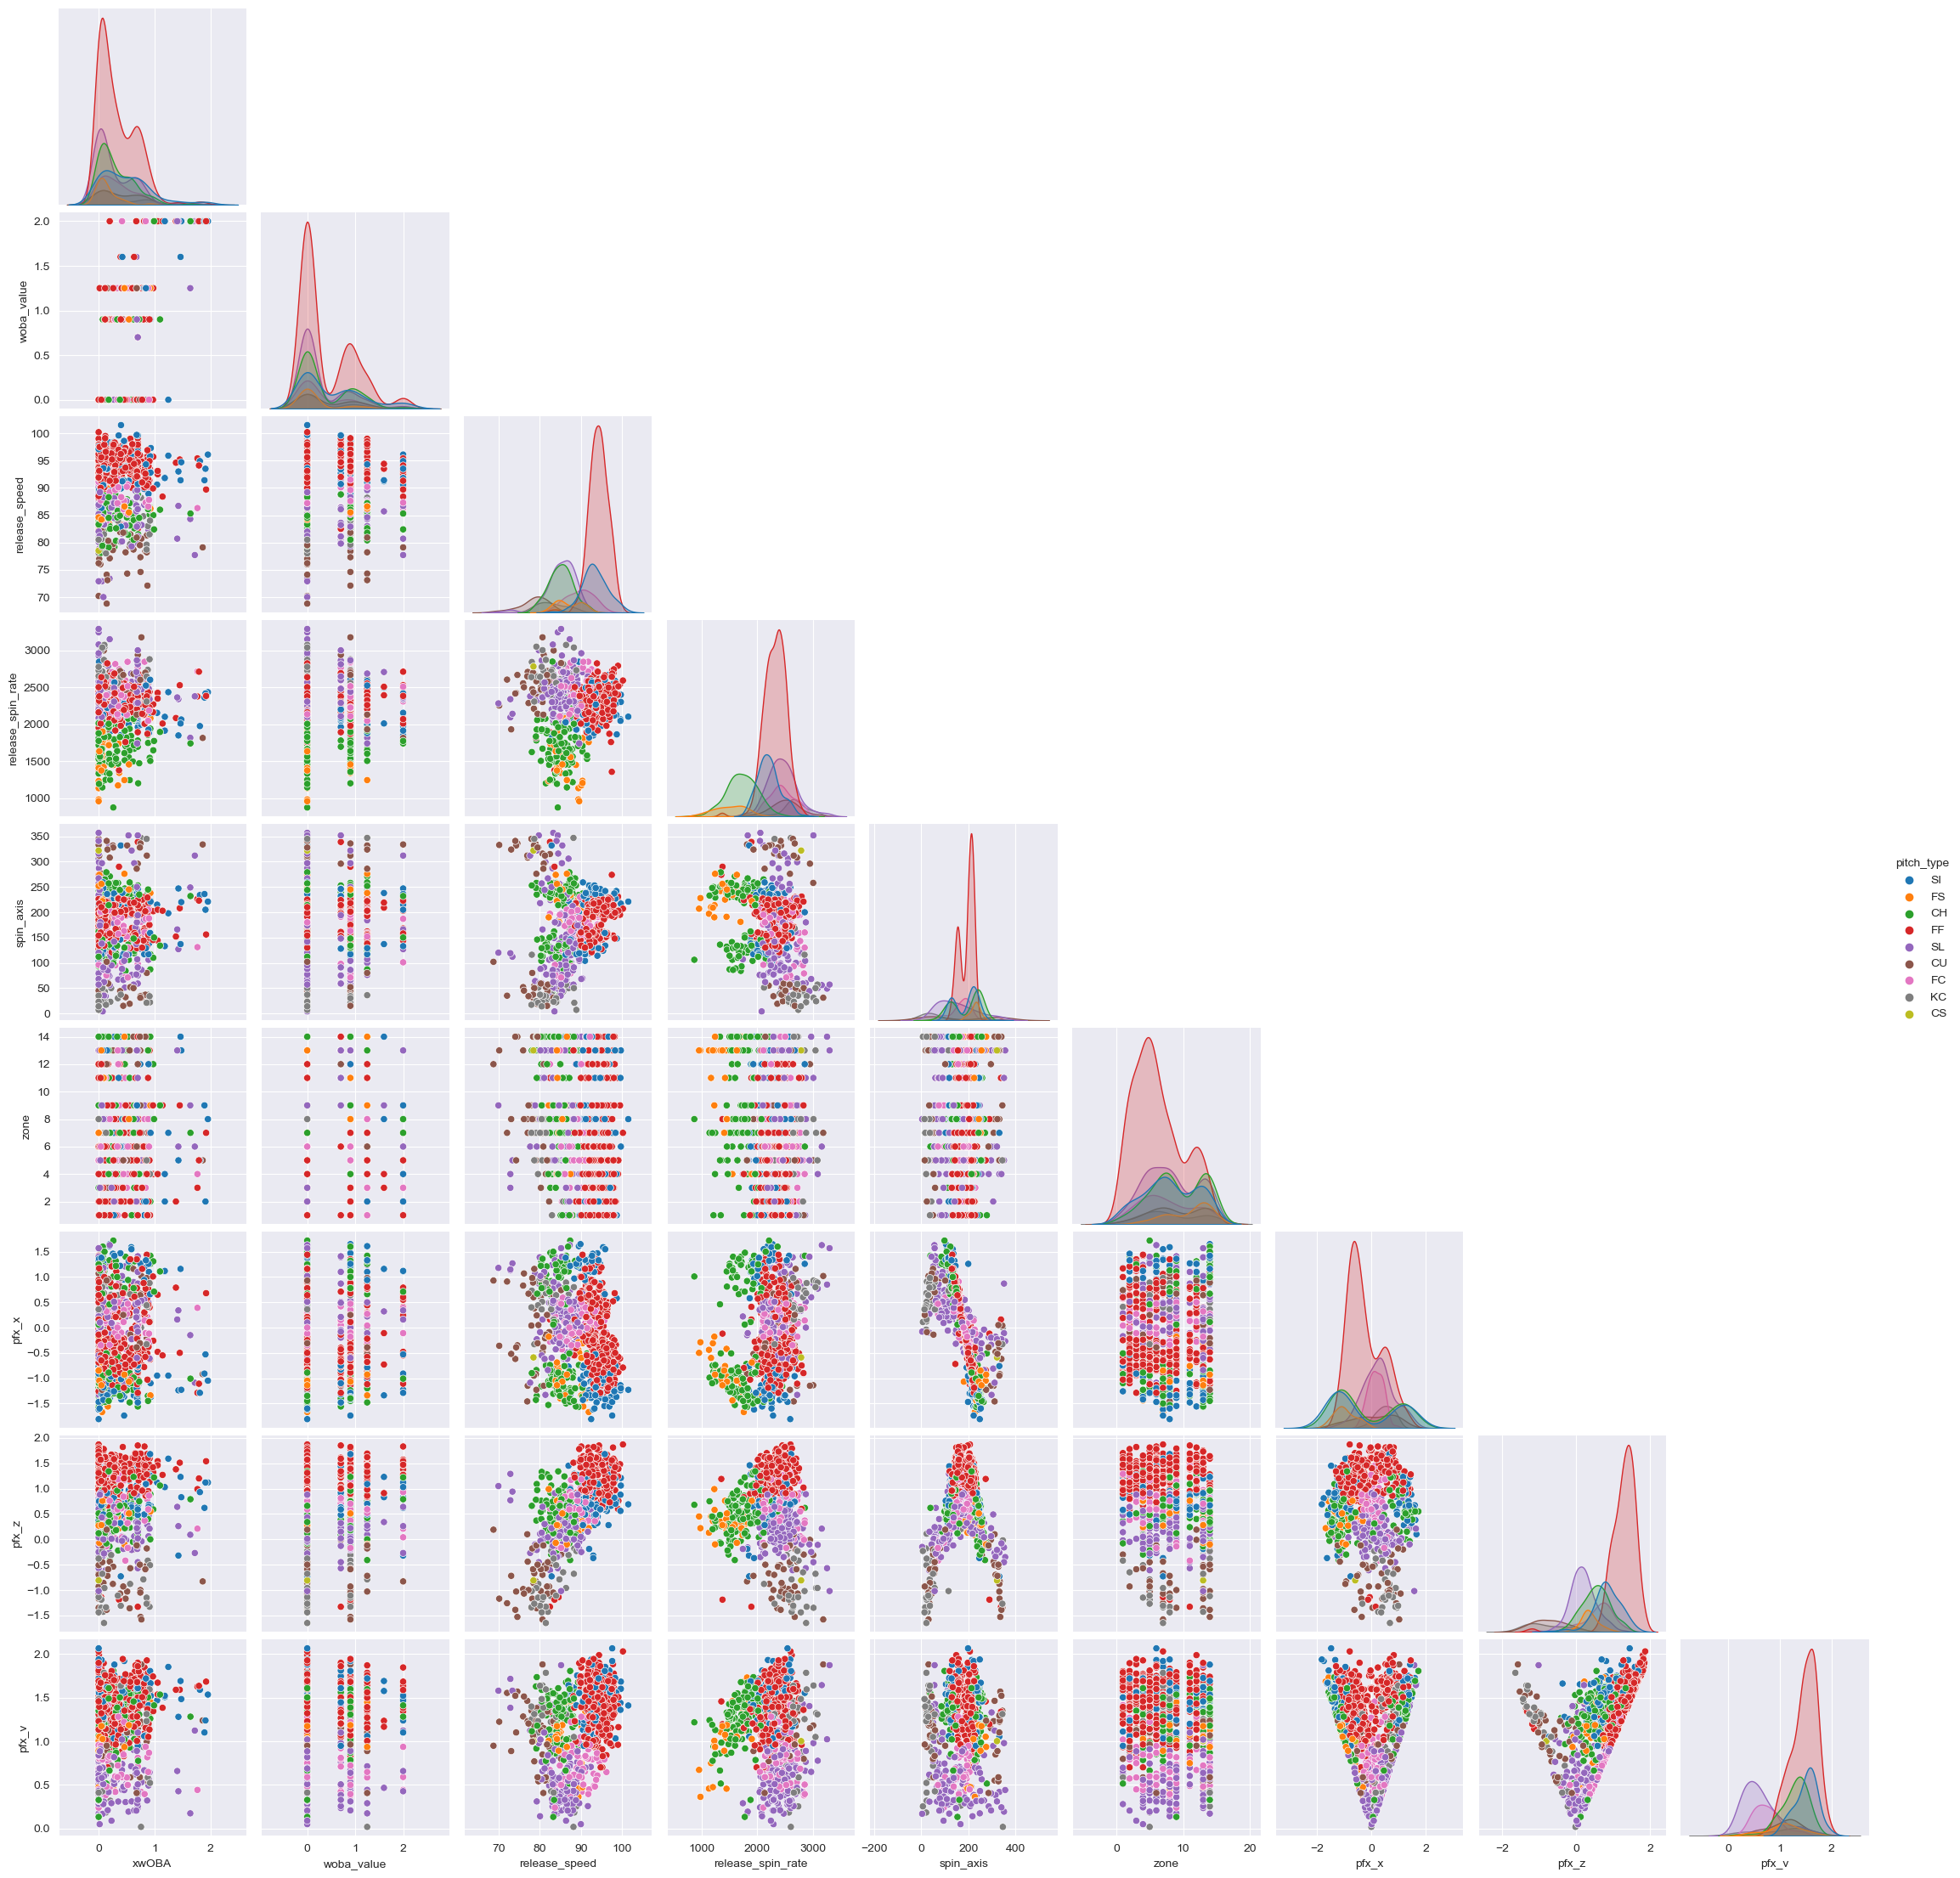

In [74]:
# exploration
import seaborn as sns

sns.pairplot(marte_vs[['xwOBA', 'woba_value', 'p_throws', 'pitch_type', 'release_speed', 'release_spin_rate', 'spin_axis', 'zone', 'pfx_x', 'pfx_z', 'pfx_v']], corner=True, hue='pitch_type')

/Users/tpubz/miniconda3/envs/notebooks/lib/python3.10/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='xwOBA', ylabel='Density'>

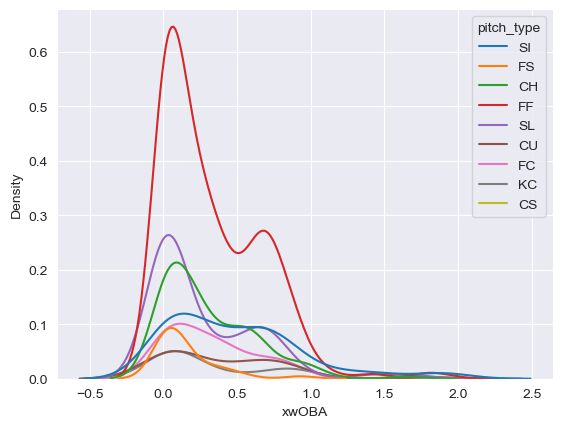

In [75]:
sns.kdeplot(marte_vs.xwOBA, hue=marte_vs.pitch_type)

<AxesSubplot:xlabel='xwOBA', ylabel='Count'>

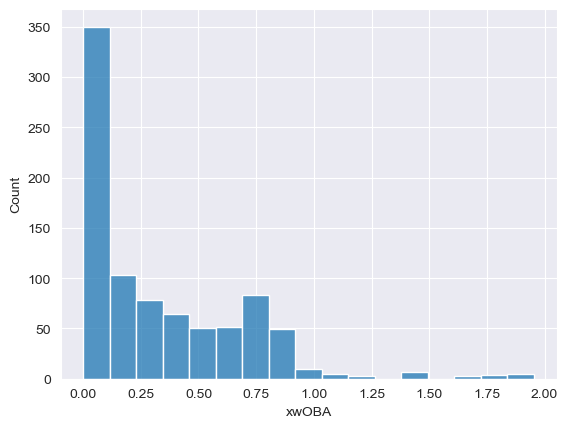

In [114]:
sns.histplot(marte_vs, x='xwOBA')  # show need for response transformation

<AxesSubplot:ylabel='Count'>

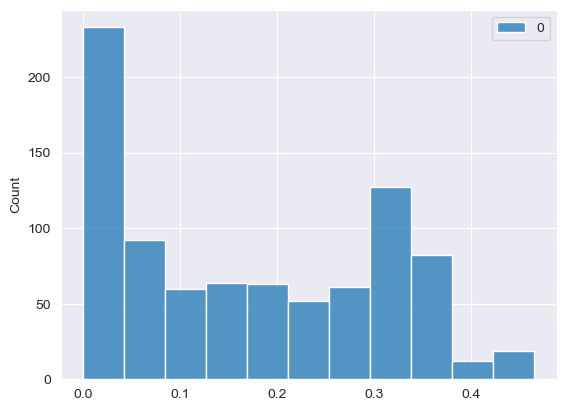

In [136]:
from sklearn.preprocessing import PowerTransformer

# Yeo-Johnson transformation of output
pt_out = PowerTransformer(standardize=False)
# extract target and convert to 1D array
y_xwOBA = marte_vs.xwOBA.to_numpy().reshape(-1, 1)
# transformation
trx_xwOBA = pt_out.fit_transform(y_xwOBA)
sns.histplot(trx_xwOBA)

<AxesSubplot:ylabel='Count'>

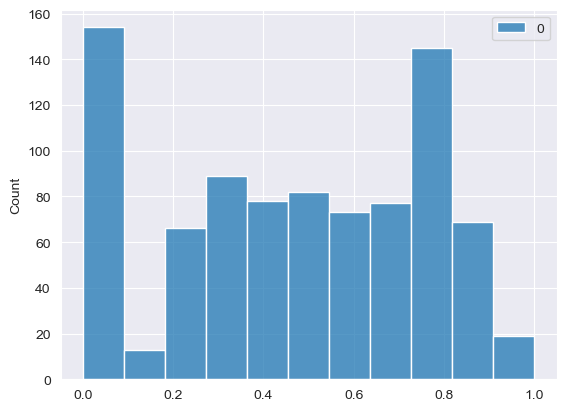

In [149]:
from sklearn.preprocessing import QuantileTransformer, quantile_transform
# qt transformation output

l1p_xwOBA = quantile_transform(
    y_xwOBA, n_quantiles=6, output_distribution="uniform", copy=True
).squeeze()
sns.histplot(l1p_xwOBA)

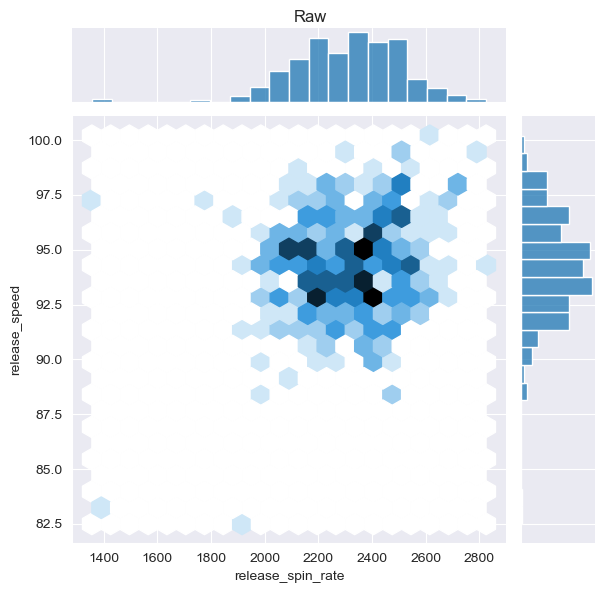

In [76]:
ff = marte_vs.groupby(['pitch_type']).get_group('FF')
g = sns.jointplot(data=ff, x='release_spin_rate', y='release_speed', kind='hex')
g.fig.suptitle("Raw")
g.fig.subplots_adjust(top=0.95)

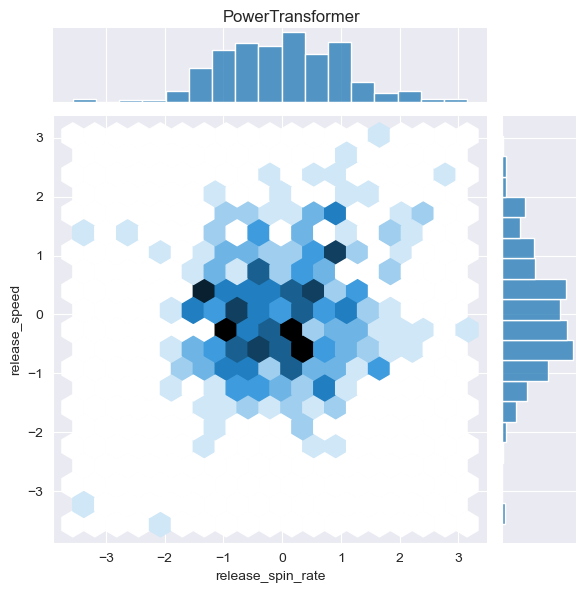

In [77]:
# used for positive values
pt = PowerTransformer(method='box-cox')
bc_trx = pt.fit_transform(ff[['release_spin_rate', 'release_speed']])
# convert to df
bc_trx = pd.DataFrame(bc_trx, columns=pt.get_feature_names_out())

g = sns.jointplot(data=bc_trx, x='release_spin_rate', y='release_speed', kind='hex')
g.fig.suptitle("PowerTransformer")
g.fig.subplots_adjust(top=0.95)

## Transformations
A common mistake is to apply transformations to the entire data before splitting into training and test sets. This will bias the model evaluation because information would have leaked from the test set to the training set.

In [78]:
marte_vs_trx = pd.get_dummies(data=marte_vs, columns=['pitch_type', 'zone'])
marte_vs_trx = pd.get_dummies(data=marte_vs_trx, columns=['p_throws'], drop_first=True)
marte_vs_trx.head()

,xwOBA,woba_value,game_year,pitcher,release_speed,release_spin_rate,spin_axis,pfx_x,pfx_z,pfx_v,...,zone_5,zone_6,zone_7,zone_8,zone_9,zone_11,zone_12,zone_13,zone_14,p_throws_R
0,0.709,0.9,2022,596001,92.9,2303.0,211.0,-1.15,0.68,1.336001,...,1,0,0,0,0,0,0,0,0,1
1,0.262,0.0,2022,596001,92.6,2316.0,204.0,-1.05,0.80,1.320038,...,0,0,0,0,1,0,0,0,0,1
2,0.231,0.0,2022,596001,93.0,2245.0,219.0,-1.13,0.79,1.378768,...,0,0,0,1,0,0,0,0,0,1
3,0.117,0.0,2022,518397,93.3,2189.0,135.0,1.19,0.28,1.222497,...,0,0,0,1,0,0,0,0,0,0
4,0.438,0.0,2022,502171,94.1,2126.0,221.0,-1.34,0.45,1.413542,...,0,0,0,0,0,0,0,0,0,1


In [93]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

X = marte_vs.drop(columns=['xwOBA', 'pfx_x', 'pfx_z'])  # remove response var and extra features
y = marte_vs.xwOBA
# split data into training and testing sets

X = sm.add_constant(X)   # only needed for sm (not smf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1642)

print('Train set shape\n',X_train.shape, y_train.shape)
print('Test set shape\n',X_test.shape, y_test.shape)
print('---')

Train set shape
 (605, 11) (605,)
Test set shape
 (260, 11) (260,)
---


In [94]:
from sklearn.preprocessing import PowerTransformer

num_feats = ['release_speed', 'release_spin_rate', 'spin_axis', 'pfx_v']
# used for positive values
pt = PowerTransformer(method='box-cox')
# get a transformed series of numerical features
X_train_trx = pt.fit_transform(X_train[num_feats])
# overwrite raw numerical data
X_train[num_feats] = X_train_trx

# transform the test set with the trained lambdas
X_test_trx = pt.transform(X_test[num_feats])
# overwrite raw numerical dataframe
X_test[num_feats] = X_test_trx

     const  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
653    1.0        0.00       2019   608032        R         SL      -0.651531   
521    1.0        1.25       2020   542881        L         FF       0.252326   
305    1.0        0.00       2021   663978        R         FF       1.634647   
613    1.0        0.00       2019   523260        R         FF       1.556881   
78     1.0        0.90       2022   570632        R         CH       0.212136   

     release_spin_rate  spin_axis  zone     pfx_v  
653           0.944836  -1.362737     1 -1.841994  
521           0.486095  -0.488739    11  1.427487  
305          -0.157442   0.402821     5  1.035856  
613          -1.337763   0.688941     4 -0.191867  
78           -1.243193   0.849608     8 -0.264071  
     const  woba_value  game_year  pitcher p_throws pitch_type  release_speed  \
440    1.0         0.7       2021   592865        R         SI       1.404231   
219    1.0         0.0       2022   628

## Modeling
### Naive Model

In [106]:
# Marte's xwOBA for last 4 seasons == .348
from sklearn.metrics import *

print(y.mean())
y_same_xwOBA = pd.Series(.348, index=y.index)
# if squared is false then rmse
naive_rmse = mean_squared_error(y_true=y, y_pred=y_same_xwOBA, squared=True)
print(f"naive mse: {naive_rmse}")

naive_r2 = r2_score(y, y_same_xwOBA)
print(f"naive r2 score: {naive_r2}")

0.331171098265896
naive mse: 0.12999878034682077
naive r2 score: -0.0021833303206431065
